In [141]:
import numpy as np
import scipy.stats as sts
np.random.seed(123)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

[-3, 7, 0, 0.5]

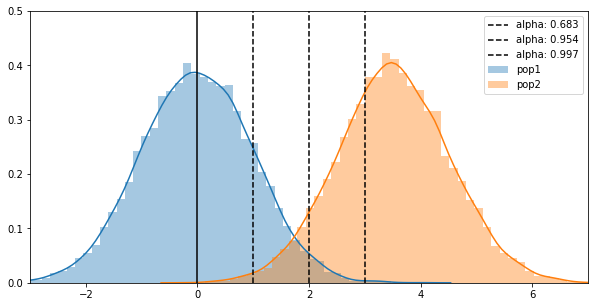

In [244]:
pop1 = sts.norm.rvs(loc=0, scale=1, size=10000)
pop2 = sts.norm.rvs(loc=3.5, scale=1, size=10000)
plt.figure(figsize=(10,5))

sb.distplot(pop1, label='pop1')
sb.distplot(pop2, label='pop2')
plt.plot([0.0,0.0],[0.0,0.5], 'k-')

for i in range(1,4):
    alpha = 1 - sts.norm.sf(i)*2
    _, cur_x = sts.norm.interval(alpha)
    plt.plot([cur_x]*2, [0.0, 0.5], 'k--', label='alpha: {:.3f}'.format(alpha))
    
plt.legend()
plt.axis([-3,7,0,0.5])

# Exercises

## Question:
#### Find the x of a standard gaussian curve, such that the cumulative probability for x equals 0.95 (i.e., type I error <= 0.05)
#### Solution:

In [245]:
from scipy.optimize import root

def confidence(x, alpha=0.95):
    """
    Return x for a given confidence
    alpha must be in range[0, 1]
    """
    return sts.norm.cdf(x) - alpha

sol = root(confidence, 1) # the 1 is the initialization value
sol.x

array([1.64485363])

## Question:
#### For the given populations, how large will be the type II error (pop2 <= sol.x)?
#### Solution:

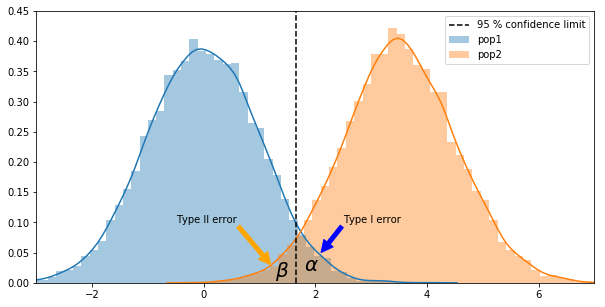

In [246]:
# Let's first recall what error of type I and II mean

# type I error means:
# we reject the null hypothesis, although it is correct

# type II error means:
# we accept the null hypothesis, although it is wrong

plt.figure(figsize=(10,5))

sb.distplot(pop1, label='pop1')
sb.distplot(pop2, label='pop2')
plt.plot([sol.x, sol.x], [0.,0.5], 'k--', label='95 % confidence limit')
plt.legend()
plt.axis([-3,7,0,0.45])

plt.annotate(s='Type I error', xy=(2.1,0.05), xytext=(2.5,0.1), arrowprops={'shrink': 1.7, 'color': 'blue'})
plt.annotate(s='Type II error', xy=(1.2,0.03), xytext=(-0.5,0.1), arrowprops={'shrink': 1.7, 'color': 'orange'})
plt.annotate(s='$\\alpha$', xy=(1.8,0.02), size=20)
plt.annotate(s='$\\beta$', xy=(1.28,0.01), size=20);

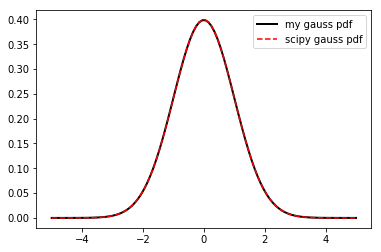

In [247]:
# let's define a fitting function

def gauss(x, x0, sigma, norm):
    return norm*np.exp(-(x-x0)**2 / (2*sigma**2))/(np.sqrt(2*np.pi)*sigma)

# control: is my gauss function accurate? -yes!
x = np.linspace(-5,5,100)
plt.plot(x, gauss(x, 0, 1, 1), 'k-', linewidth=2, label='my gauss pdf')
plt.plot(x, sts.norm.pdf(x), 'r--',label='scipy gauss pdf')
plt.legend()

In [248]:
# next we define the fitting function

from scipy.optimize import curve_fit

def binned_fit(data, n_bins, print_error=True):
    y, bins, _ = plt.hist(data, bins=n_bins, density=True, label='histogram')
    b = bins[:-1] + (bins[1] - bins[0])/2
    params, cov = curve_fit(gauss, b, y)
    
    x_plot = np.linspace(np.min(bins)-1,np.max(bins)+1)
    plt.plot(x_plot, gauss(x_plot, *params), 'r--', label='best fit')
    plt.legend()
    
    # standard deviation errors on the fit parameters
    perr = np.sqrt(np.diag(cov))
    if print_error == True:
        print('x_0: {:.4f} +- {:.4f}'.format(params[0], perr[0]))
        print('sigma: {:.4f} +- {:.4f}'.format(params[1], perr[1]))
        print('norm: {:.4f} +- {:.4f}'.format(params[2], perr[2]))
    return params, cov, perr

x_0: -0.0031 +- 0.0092
sigma: 1.0132 +- 0.0092
norm: 1.0049 +- 0.0079


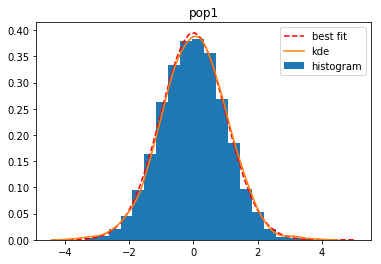

x_0: 3.5024 +- 0.0083
sigma: 0.9961 +- 0.0083
norm: 0.9956 +- 0.0072


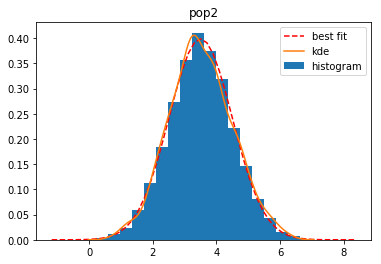

In [249]:
# Let's make the fits
_c = 1
for pop in (pop1, pop2):
    cur_params, cur_cov, cur_perr = binned_fit(pop, 20)
    sb.distplot(sts.norm.rvs(loc=cur_params[0], scale=cur_params[1], size=1000), label='kde', hist=False)
    plt.legend()
    plt.title('pop'+str(_c))
    plt.show()
    _c += 1

In [250]:
# eventually, we have all we need to calculate the type II error for the given population data

import scipy.integrate as integrate
result = integrate.quad(lambda x: sts.norm.pdf(x,loc=cur_params[0], scale=cur_params[1]), -np.inf, sol.x)

In [251]:
print('type II error: {:.5f} +- {:.5f}'.format(*result))
# we would wrongly assume that the null hypothesis is fulfilled

type II error: 0.03110 +- 0.00000


# Power of the test

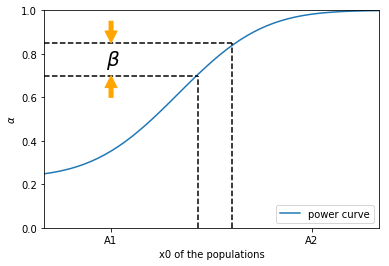

In [252]:
# power of a test is defined as p = 1 - beta

# example for determination of the best test

x = np.linspace(0, 10, 100)
plt.plot(x, (sts.norm.cdf(x, loc=2, scale=1)+0.3)/1.3, label='power curve')
plt.xlim(0,5)
plt.xlabel('x0 of the populations')
plt.ylabel('$\\alpha$');

plt.plot([0,2.3],[0.7,0.7], 'k--')
plt.plot([2.3,2.3],[0.0,0.7], 'k--')

plt.plot([0,2.8],[0.85,0.85], 'k--')
plt.plot([2.8,2.8],[0.0,0.85], 'k--')

plt.annotate(s='', xy=(1.,0.7), xytext=(1,0.6), arrowprops={'shrink': 1.7, 'color': 'orange'})
plt.annotate(s='', xy=(1.,0.85), xytext=(1,0.95), arrowprops={'shrink': 1.7, 'color': 'orange'})
plt.annotate(s='$\\beta$', xy=(0.93,0.75), size=20)

plt.axis([0,5,0,1])
plt.legend(loc='lower right');
plt.xticks([1, 4], ['A1', 'A2']);

# 1. fix alpha (e.g., 0.05 or 0.01)
# 2. look for alpha, that minimizes beta
# 3. if beta remains to large for your purposes
#    increase alpha
#    increase sample size
#    use other test

# After here incomplete

# Treating outliers - Chauvenet's Criterion

In [ ]:
def chauvenets_criterion(sample):
    x0, std, size = sample.mean(ddof=1), sample.std(ddf=1), len(sample)
    eta0 = 0.5
    def prob(x):
        pass
    # prob(X >= x)
    eta = size #* prob
    

# Make a likelihood fit

In [322]:
from scipy.optimize import minimize

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
#http://www.chadfulton.com/fulton_statsmodels_2017/sections/4-maximum_likelihood_estimation.html

def log_likelihood(data, *p):
    return -np.log(np.sum(gauss(data, p[0], p[1], p[2])))

In [324]:
for i in ((1,2,3), (0, 1.2, 1.2), (0, 1, 1)):
    print(log_likelihood(pop1, *i))

-8.484604533410815
-8.028995013210233
-7.945649164441183


In [331]:
res = minimize(log_likelihood, np.zeros(3), args=(pop1,), method='L-BFGS-B')
res.x

IndexError: tuple index out of range

In [307]:
pop1

array([ 0.2917123 ,  0.26009526,  0.00203645, ...,  1.24469802,
       -0.42768133, -0.30829495])